# Data Scientist exercice 

### Written by Isabelle Vea

Time taken: ~2h with app creation

### Approach to solve this exercise
To find the minimum sample size needed to obtain a normal distribution for the sampled average numbers of neighbors, I followed the following steps:

- Calculate for each one dimension coordinate the minimum and maximum values given by the radius. Since we have one dimension, it is going to be a range of numbers.

- For each coordinate and range based on the radius, count how many values in the coordinate list are within that range and store the number for each coordinate. Do not forget to remove the coordinate itself.

Once I have these numbers, I can start looking at how sampling number affects the final boostrap distribution.


- Write a code that randomly samples n numbers of coordinate and take the counts within my radius and average the counts. I boostrap it for a total of 1000 replicates, each mean is collected into a list.

- Plot the means collected into an histogram and build a qqplot to visualize the distribution. I also decided to use. statistical test (Shapiro-Wilk normality test to test if the distribution is normal).

- Visualize just as a proof of concept how the distribution looks like with a very small sample size (n=3) and a ver large one (n=100).

- I should see that with a large sample size, the boostrap distribution tends to follow a normal distribution. I can also use the streamlit app I have build to visualiza the range the sampling number where the minimum number for a normal distribution lie.

- My next step is to find a way to identify what sample size will give a normal distribution. In that case I run bootstraps for a range of sampling number I established base on my previous visualization, and run the normality test for each of them and store the p-values.

- Plot the p-values (y) against (sampling number) and decide on my p-value threshold. This will give me the minimum sample size that will lead to a boostrap distribution considered as Gaussian.


In [163]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import random
import math

In [29]:
# Dataset
data = pd.read_csv("dataset.csv", header=None)
data.rename(columns={0: 'x'}, inplace=True)
data.head()

,x
0,28.026608
1,1014.883103
2,13.928090
3,9.229389
4,1019.805279


In [30]:
data.describe()

,x
count,800.000000
mean,638.466539
std,480.331371
min,-9.362703
25%,29.317828
50%,1004.188078
75%,1012.072942
max,1019.887934


In [35]:
## calculate range of each coordinate within the radius =5
r = 5

def create_radius_range(df,radius):
    ''' Adding and subtracting a radius value into the first column of the dataframe
    Input: dataframe with at least mone column
    Output: dataframe with column 'min' and 'max' added
    '''
    df['max'] = np.add(df['x'],radius)
    df['min'] = np.subtract(df['x'],radius)
    return df
    

In [36]:
r = 5
data_range = create_radius_range(data,r)

In [37]:
data_range.head()

,x,max,min
0,28.026608,33.026608,23.026608
1,1014.883103,1019.883103,1009.883103
2,13.928090,18.928090,8.928090
3,9.229389,14.229389,4.229389
4,1019.805279,1024.805279,1014.805279


In [42]:
# checking for duplicates
data[data.duplicated()]

,x,max,min


In [ ]:
#no duplicates so I will subtract my count by 1 values in the next function

In [67]:
# creating my list of 
# I used this resource to make the function: https://www.geeksforgeeks.org/python-numbers-list-within-given-range/

def count_values_in_range(df):
    #creating my list of range from the df
    ranges = [(l, r) for l, r in zip(df['min'], df['max'])]
    
    #extracting x col as a list
    coordinates = df['x'].tolist()
    
    count_range = lambda l, r: sum(l <= x <= r for x in coordinates) - 1 # this function will count the elements in my list of coordinates within a given range
    ranges_count_dict = [{'range': f'({l}, {r})', 'count': count_range(l, r)} for l, r in ranges]
    ranges_df = pd.DataFrame(ranges_count_dict)
    
    ranges_df['x'] = coordinates
    ranges_df = ranges_df.drop('range', axis=1)
    return ranges_df


In [70]:
counts = count_values_in_range(data)
counts.head()

,count,x
0,57,28.026608
1,247,1014.883103
2,34,13.928090
3,43,9.229389
4,138,1019.805279


In [122]:
def bootstrap(df, n_sample, n_reps):
    min_n_sample = 2
    max_n_sample = len(df) - 10 # I set up this maximum n_sample (from looking at the plot distribution) because otherwise the boostrap doesn't make sense anymore as it samples almost all the values and will give the same mean or at least it becomes skewed.
    
    if not (min_n_sample <= n_sample <= max_n_sample):
        raise ValueError(f"the number of sample is not between {min_n_sample} and {max_n_sample}")
    bootstrap_replicates = [sum(random.sample(df['count'].tolist(), n_sample)) / n_sample for _ in range(n_reps)]

    return bootstrap_replicates
    

In [ ]:
#Let's look at a couple of examples

(array([ 1.,  0.,  2.,  0.,  2.,  3.,  8.,  7., 10.,  8., 22., 29., 39.,
        42., 34., 50., 59., 60., 50., 69., 60., 64., 75., 57., 52., 51.,
        40., 23., 25., 23.,  7., 10.,  6.,  3.,  3.,  3.,  2.,  0.,  0.,
         1.]),
 array([126.74   , 128.21025, 129.6805 , 131.15075, 132.621  , 134.09125,
        135.5615 , 137.03175, 138.502  , 139.97225, 141.4425 , 142.91275,
        144.383  , 145.85325, 147.3235 , 148.79375, 150.264  , 151.73425,
        153.2045 , 154.67475, 156.145  , 157.61525, 159.0855 , 160.55575,
        162.026  , 163.49625, 164.9665 , 166.43675, 167.907  , 169.37725,
        170.8475 , 172.31775, 173.788  , 175.25825, 176.7285 , 178.19875,
        179.669  , 181.13925, 182.6095 , 184.07975, 185.55   ]),
 <BarContainer object of 40 artists>)

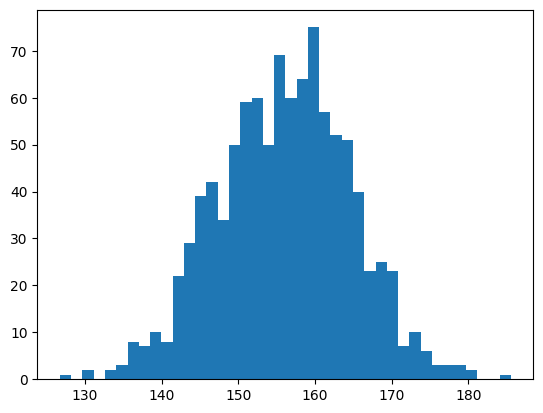

In [206]:
bootstrap_large =bootstrap(counts, 100, 1000)
plt.hist(bootstrap_large, bins=40)

(array([ 3., 13., 19., 12.,  2.,  1.,  5., 16., 22., 21.,  9., 18., 33.,
        52., 62., 34., 15., 10., 13., 33., 41., 35., 39., 42., 36., 55.,
        82., 36., 19., 10., 17., 17., 32., 30., 18., 26., 14., 21., 32.,
         5.]),
 array([ 36.33333333,  41.93333333,  47.53333333,  53.13333333,
         58.73333333,  64.33333333,  69.93333333,  75.53333333,
         81.13333333,  86.73333333,  92.33333333,  97.93333333,
        103.53333333, 109.13333333, 114.73333333, 120.33333333,
        125.93333333, 131.53333333, 137.13333333, 142.73333333,
        148.33333333, 153.93333333, 159.53333333, 165.13333333,
        170.73333333, 176.33333333, 181.93333333, 187.53333333,
        193.13333333, 198.73333333, 204.33333333, 209.93333333,
        215.53333333, 221.13333333, 226.73333333, 232.33333333,
        237.93333333, 243.53333333, 249.13333333, 254.73333333,
        260.33333333]),
 <BarContainer object of 40 artists>)

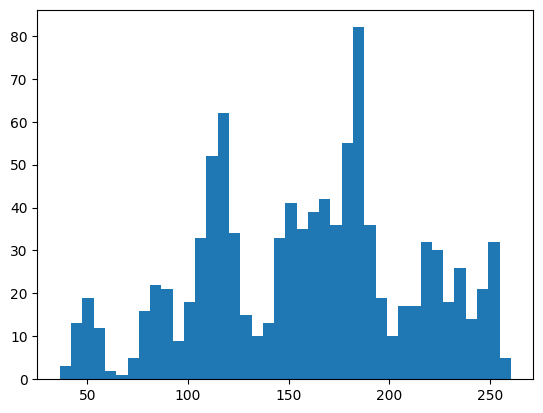

In [128]:
bootstrap_small =bootstrap(counts, 3, 1000)
plt.hist(bootstrap_small, bins=40)

In [170]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
# resource that helped me decided on the normality test: https://towardsdatascience.com/choose-the-appropriate-normality-test-d53146ca1f1c#:~:text=Shapiro%2DWilk%20test%2C%20Kolmogorov%E2%80%93,D'Agostino%2DPearson's%20K%C2%B2%20test&text=Normal%20distribution%2C%20also%20known%20as,mean%20and%20the%20standard%20deviation. 

stats.shapiro(bootstrap_large)


ShapiroResult(statistic=0.9973843097686768, pvalue=0.10754899680614471)

In [135]:
stats.shapiro(bootstrap_small)

ShapiroResult(statistic=0.9790865778923035, pvalue=8.414580837667884e-11)

From the shapiro-wilk test, we see that when we use a small sample size, the test rejects our normality hypothesis, while in a large sample, it does not reject the normality hypothesis, so we consider the bootstrap distribution normal.

In [184]:
#The next step is to create my p-value plot against sample size for 1000 replicates and a n_sample range between 2 and 100
def SW_bootstrap(df):
    n_sample_range = range(2,100)
    n_reps = 1000
    
    p_vals = [stats.shapiro(bootstrap(df, x, n_reps))[1]
              for x in n_sample_range]
    p_vals_df = pd.DataFrame({'n_sample': n_sample_range, 'p_value': p_vals})
    p_vals_df['log p_value'] = -np.log10(p_vals_df['p_value'])
        
    
    return p_vals_df

In [185]:
final_pval = SW_bootstrap(counts)

In [186]:
final_pval 

,n_sample,p_value,log p_value
0,2,3.211850e-17,16.493245
1,3,2.042636e-08,7.689809
2,4,1.579535e-04,3.801471
3,5,2.882994e-02,1.540156
4,6,2.805316e-01,0.552018
...,...,...,...
93,95,1.752570e-01,0.756325
94,96,1.914223e-01,0.718007
95,97,4.307809e-01,0.365744
96,98,9.702017e-01,0.013138


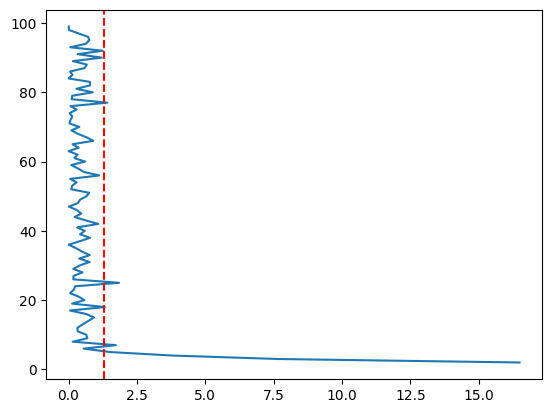

In [192]:
plt.plot(final_pval['log p_value'],final_pval['n_sample'])
plt.axvline(x=-np.log10(0.05), color='r', linestyle='--', label=f'Threshold: {-np.log10(0.05)}')


In [210]:
#smallest number with a p-value threshold of 0.05
final_pval[final_pval['p_value'] >= 0.05].sort_values(by='n_sample').head(1)

,n_sample,p_value,log p_value
4,6,0.280532,0.552018


In [209]:
#smallest number with a p-value threshold of 0.01
final_pval[final_pval['p_value'] >= 0.01].sort_values(by='n_sample').head(1)

,n_sample,p_value,log p_value
3,5,0.02883,1.540156


## Conclusion
### Depending on the p_value threshold the minimum number of samples to use to calcualte the average count of neighbors in a radius of 5 for the given coordinate is 6 (p-value > 0.05) or 5 (p-value > 0.01)

In [222]:
final_pval[final_pval['p_value'] >= 0.05].sort_values(by='n_sample').head(1)

,n_sample,p_value,log p_value
4,6,0.280532,0.552018


#### Notes: I created an app to explore the change in distribution and created the p-value by sample size but there is a problem with the plot, it is not supposed to change when changing sample size in the app. I tried to set up a random seed but it does not seem to work I did not have time to fixe this problem.